<a href="https://colab.research.google.com/github/ErikaDenisse29/ColabFiles/blob/main/Actividad_8_Visualizaci%C3%B3n_sem%C3%A1ntica_de_palabrasFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Actividad 8: Visualización semántica de palabras utilizando embeddings y t-SNE.**

---


**Objetivo de la actividad.**

Aplicar técnicas de representación vectorial de palabras (embeddings) y de reducción de dimensionalidad (t-SNE) para generar una visualización semántica que permita identificar relaciones, similitudes y agrupamientos entre términos.


---
**Instrucciones**

Explora la representación semántica de palabras e identifica los diferentes ominios temáticos contenidos en el conjunto de datos proporcionado mediante la visualización 2D de embeddings de palabras. Realiza y define las actividades de preprocesamiento del texto (si lo crees necesario) para que fácilmente puedas identificar en la visualización lo siguiente:

**¿Cuántos dominios o grupos de datos puedes identificar visualmente en la gráfica?**

*Puedo identificar tres grupos principales de palabras*

**¿Cuáles son esos dominios?**

Basándome en el agrupamiento visual y el significado semántico de las palabras los dominios puedo describirlos como:

*•	Términos computacionales: palabras en círculo verde como programación, informática, computación, software, ciberseguridad, velocidad.*

*•	Deportes: palabras en circulo azul como olimpismo, deporte, futbol, baloncesto, equipo*

*•	Política: palabras en círculo rojo como ciudadanía, derecho, ideologías, políticos, democracia.*




INICIANDO ENTRENAMIENTO DE EMBEDDINGS
Codificación detectada: ISO-8859-1
Intentando con codificación: ISO-8859-1
CSV cargado exitosamente con codificación: ISO-8859-1
Columna de texto identificada: 'frase'

Se cargaron 148 textos desde el CSV
Ejemplos de textos cargados:
   1. La ciberseguridad protege la información digital.
   2. La inteligencia artificial transforma múltiples industrias.
   3. El baloncesto combina velocidad, técnica y trabajo en equipo.

 Estadísticas del corpus preprocesado:
   Tamaño del corpus: 148 documentos
   Total de tokens: 501
   Longitud promedio: 3.4 tokens por documento
   Longitud mínima: 1 tokens
   Longitud máxima: 5 tokens

🔍 Ejemplo de tokens preprocesados:
   Documento 1: ['ciberseguridad', 'información', 'digital']
   Documento 2: ['inteligencia', 'artificial', 'transforma', 'múltiples', 'industrias']

Entrenando modelo Word2Vec...
Entrenando modelo FastText...

EVALUACIÓN DE MODELOS:

Palabras más frecuentes en el vocabulario:
   1. cibersegurid

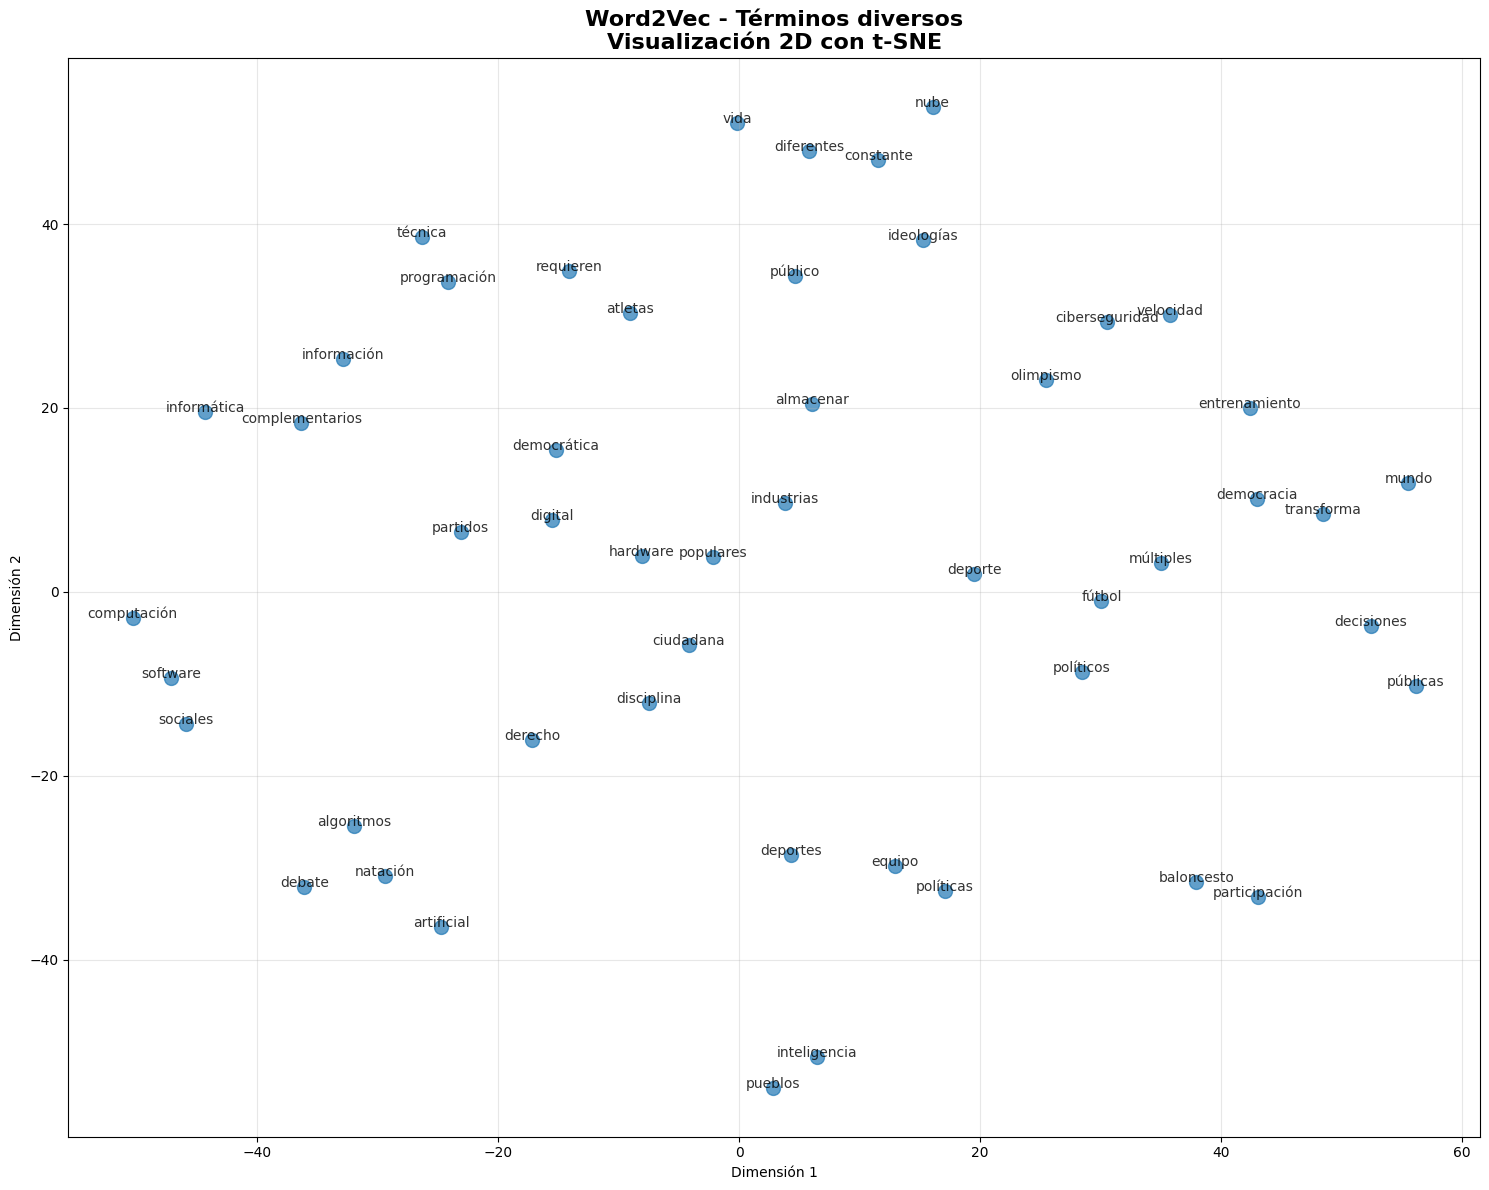

In [43]:

!pip install gensim
!pip install chardet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import re
from gensim.models import Word2Vec, FastText
import chardet
import os
import shutil

def detectar_codificacion_archivo(ruta_archivo):

    with open(ruta_archivo, 'rb') as f:
        resultado = chardet.detect(f.read())
    return resultado['encoding']

def preprocesar_texto_simple(texto):
    if pd.isna(texto):
        return []

    texto = str(texto).lower()
    texto = re.sub(r'[^a-záéíóúñü0-9\s]', ' ', texto)
    tokens = texto.split()

    stop_words = {
        'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para',
        'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o',
        'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también','permite','asegura','son','es','fortalece', 'protege','todo','elecciones',
        'atender', 'combina', 'estado','uno','necesidades','libres', 'esenciales', 'base','busca','representan', 'través', 'unión','buscan', 'mejorar','cuerpo','datos','trabajo'
    }

    tokens = [token for token in tokens if token not in stop_words]
    return tokens

def preparar_corpus_5():

    textos_5 = []
    ruta_archivo = "drive/MyDrive/corpus_5_temas.csv"

    try:
        try:
            codificacion = detectar_codificacion_archivo(ruta_archivo)
            print(f"Codificación detectada: {codificacion}")
        except:
            codificacion = 'utf-8'
            print("No se pudo detectar codificación, usando UTF-8 por defecto")

        codificaciones = [codificacion, 'latin-1', 'iso-8859-1', 'cp1252', 'utf-8']

        for encoding in codificaciones:
            try:
                print(f"Intentando con codificación: {encoding}")
                df = pd.read_csv(ruta_archivo, encoding=encoding)
                print(f"CSV cargado exitosamente con codificación: {encoding}")
                break
            except UnicodeDecodeError:
                print(f"Error con codificación {encoding}, probando siguiente...")
                continue
            except Exception as e:
                print(f"Error inesperado con {encoding}: {e}")
                continue
        else:
            print("No se pudo cargar el CSV con ninguna codificación")
            return []


        posibles_columnas_texto = ['frase', 'text']
        columna_texto = None

        for col in posibles_columnas_texto:
            if col in df.columns:
                columna_texto = col
                break

        if columna_texto is None:
            for col in df.columns:
                if df[col].dtype == 'object' and df[col].str.len().mean() > 10:
                    columna_texto = col
                    break

            if columna_texto is None and len(df.columns) > 0:
                columna_texto = df.columns[0]
                print(f"No se encontraron columnas de texto obvias. Usando la primera columna: '{columna_texto}'")
            else:
                print(f"Columna de texto identificada: '{columna_texto}'")
        else:
            print(f"Columna de texto identificada: '{columna_texto}'")

        textos_5 = df[columna_texto].dropna().astype(str).tolist()
        textos_5 = [texto.strip() for texto in textos_5 if texto.strip()]

        print(f"\nSe cargaron {len(textos_5)} textos desde el CSV")

        if textos_5:
            print(f"Ejemplos de textos cargados:")
            for i, texto in enumerate(textos_5[:3], 1):
                print(f"   {i}. {texto[:80]}{'...' if len(texto) > 80 else ''}")
        else:
            print("No se encontraron textos válidos en la columna seleccionada")
            print(f"Contenido de la columna '{columna_texto}':")
            print(df[columna_texto].head(10))

        return textos_5

    except FileNotFoundError:
        print(f" Error: No se encontró el archivo {ruta_archivo}")
        print("   Verifica la ruta y que el archivo exista")
        return []
    except Exception as e:
        print(f" Error al leer el archivo CSV: {e}")
        return []

def entrenar_modelos_embeddings():

    textos = preparar_corpus_5()

    if not textos:
        print("No se pudieron cargar textos. Saliendo...")
        return None, None

    corpus_preprocesado = [preprocesar_texto_simple(texto) for texto in textos]
    corpus_preprocesado = [doc for doc in corpus_preprocesado if doc]

    if not corpus_preprocesado:
        print(" No quedaron documentos después del preprocesamiento")
        return None, None

    print(f"\n Estadísticas del corpus preprocesado:")
    print(f"   Tamaño del corpus: {len(corpus_preprocesado)} documentos")
    print(f"   Total de tokens: {sum(len(doc) for doc in corpus_preprocesado)}")


    longitudes = [len(doc) for doc in corpus_preprocesado]
    print(f"   Longitud promedio: {np.mean(longitudes):.1f} tokens por documento")
    print(f"   Longitud mínima: {min(longitudes)} tokens")
    print(f"   Longitud máxima: {max(longitudes)} tokens")


    print(f"\n🔍 Ejemplo de tokens preprocesados:")
    for i, doc in enumerate(corpus_preprocesado[:2], 1):
        print(f"   Documento {i}: {doc[:10]}{'...' if len(doc) > 10 else ''}")

    config_w2v = {
        'vector_size': 100,
        'window': 5,
        'min_count': 2,
        'workers': 4,
        'sg': 1,
        'epochs': 30
    }

    config_ft = {
        'vector_size': 100,
        'window': 5,
        'min_count': 2,
        'workers': 4,
        'sg': 1,
        'epochs': 30,
        'min_n': 3,
        'max_n': 6
    }

    print("\nEntrenando modelo Word2Vec...")
    model_w2v = Word2Vec(
        sentences=corpus_preprocesado,
        **config_w2v
    )

    print("Entrenando modelo FastText...")
    model_ft = FastText(
        sentences=corpus_preprocesado,
        **config_ft
    )

    return model_w2v, model_ft



def evaluar_modelos(model_w2v, model_ft):

    print("\nEVALUACIÓN DE MODELOS:")
    print("=" * 50)

    palabras_frecuentes = []
    try:
        palabras_frecuentes = list(model_w2v.wv.key_to_index.keys())[:10]
        print(f"\nPalabras más frecuentes en el vocabulario:")
        for i, palabra in enumerate(palabras_frecuentes[:10], 1):
            print(f"   {i}. {palabra}")
    except:
        print("No se pudo obtener palabras frecuentes del vocabulario")
        return

    print("\n SIMILITUDES ENTRE PALABRAS MÁS FRECUENTES:")
    print("-" * 45)


    print("Similitudes Word2Vec:")
    for i in range(min(3, len(palabras_frecuentes))):
        for j in range(i+1, min(i+6, len(palabras_frecuentes))):
            palabra1, palabra2 = palabras_frecuentes[i], palabras_frecuentes[j]
            try:
                similitud = model_w2v.wv.similarity(palabra1, palabra2)
                print(f"  {palabra1} - {palabra2}: {similitud:.3f}")
            except:
                print(f"  {palabra1} o {palabra2} no en vocabulario")

    print("\nSimilitudes FastText:")
    for i in range(min(3, len(palabras_frecuentes))):
        for j in range(i+1, min(i+6, len(palabras_frecuentes))):
            palabra1, palabra2 = palabras_frecuentes[i], palabras_frecuentes[j]
            try:
                similitud = model_ft.wv.similarity(palabra1, palabra2)
                print(f"  {palabra1} - {palabra2}: {similitud:.3f}")
            except:
                print(f"  {palabra1} o {palabra2} no en vocabulario")

    print("\n👥 PALABRAS MÁS SIMILARES (automático):")
    print("-" * 35)


    palabras_para_similitud = palabras_frecuentes[:2]

    for palabra in palabras_para_similitud:
        try:
            print(f"\nPalabras similares a '{palabra}' (Word2Vec):")
            similares = model_w2v.wv.most_similar(palabra, topn=5)
            for palabra_sim, similitud in similares:
                print(f"  {palabra_sim}: {similitud:.3f}")
        except:
            print(f"  '{palabra}' no encontrada en vocabulario Word2Vec")

        try:
            print(f"Palabras similares a '{palabra}' (FastText):")
            similares = model_ft.wv.most_similar(palabra, topn=5)
            for palabra_sim, similitud in similares:
                print(f"  {palabra_sim}: {similitud:.3f}")
        except:
            print(f"  '{palabra}' no encontrada en vocabulario FastText")


def guardar_modelos(model_w2v, model_ft):
    model_w2v.save("word2vec_es.model")
    model_ft.save("fasttext_es.model")
    print("Modelos guardados exitosamente!")
    print("   Word2Vec: word2vec_es.model")
    print("   FastText: fasttext_es.model")

def cargar_modelos():
    try:
        model_w2v = Word2Vec.load("word2vec_es.model")
        model_ft = FastText.load("fasttext_es.model")
        print("Modelos cargados exitosamente!")
        return model_w2v, model_ft
    except Exception as e:
        print(f"Error al cargar modelos: {e}")
        return None, None

def generar_grafica_embeddings(model, titulo="Embeddings de Términos diversos"):

    palabras = list(model.wv.key_to_index.keys())[:50]
    vectores = np.array([model.wv[palabra] for palabra in palabras])

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    vectores_2d = tsne.fit_transform(vectores)

    plt.figure(figsize=(15, 12))
    plt.scatter(vectores_2d[:, 0], vectores_2d[:, 1], alpha=0.7, s=100)

    for i, palabra in enumerate(palabras):
        plt.annotate(palabra, (vectores_2d[i, 0], vectores_2d[i, 1]),
                    fontsize=10, alpha=0.8, ha='center')

    plt.title(f'{titulo}\nVisualización 2D con t-SNE', fontsize=16, fontweight='bold')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('embeddings_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

def main_entrenamiento():
    """Función principal de entrenamiento"""
    print("INICIANDO ENTRENAMIENTO DE EMBEDDINGS")
    print("=" * 50)

    model_w2v, model_ft = entrenar_modelos_embeddings()

    if model_w2v is None or model_ft is None:
        print("No se pudieron entrenar los modelos. Verifica los datos.")
        return

    evaluar_modelos(model_w2v, model_ft)
    guardar_modelos(model_w2v, model_ft)

    print("\nESTADÍSTICAS FINALES:")
    print(f"   Tamaño vocabulario Word2Vec: {len(model_w2v.wv.key_to_index)}")
    print(f"   Tamaño vocabulario FastText: {len(model_ft.wv.key_to_index)}")

    print("\nGenerando visualizaciones...")
    generar_grafica_embeddings(model_w2v, "Word2Vec - Términos diversos")



if __name__ == "__main__":
    main_entrenamiento()